# CPGE/LPGE Data Analysis

## FFT of the current density

* How analyse the current density (GaAs) 
* The analysis is general and applies to any time series data

The DMD code outputs current density ($ j_x, j_y, j_x $) as a function time to text files `jx_elec_tot.out`, `jy_elec_tot.out`, and `jz_elec_tot.out`. The first column is time in atomic units, the second colulmn is $j_x$, third column is $j_x$ due to contributions from the diagonal elements of the density matrix, while the fourth column is $j_x$ due to contributions from the off-diagonal elements of the density matrix. The following python script reads current density time series data for plotting and analysis. Since we are interested in the constant (DC or zero-frequency) component of the current, we can perform the fast fourier transform (FFT) to obtain the frequency domain data. The FFT is sensitive to truncation errors so we also apply windows to make the time domain data smoothly go to zero.

Below is the most recent input file used to obtain the GaAs data,

```
#DEBUG = 1
restart = 0
#compute_tau_only = 1
code = jdftx
# alg_linearize = 1 # does not work with real time laser
print_along_kpath = 1
kpath_start1 = 0,0,0
kpath_end1 = 0.375,0.75,0.375
alg_only_eimp = 0
alg_eph_sepr_eh = 1
alg_eph_need_elec = 1
alg_eph_need_hole = 0
alg_scatt = lindblad
alg_set_scv_zero = 1
alg_Pin_is_sparse = 0
alg_sparseP = 0
#alg_ddmdteq = 1
laserMode = constant
pumpMode = coherent
pumpA0 = 0.00050
pumpPoltype = Ex
pumpE = 1.50
pumpTau = 10
pump_tcenter = 100
probePoltype = LC
#probePoltype2 = RC
probeEmin = 0.8
probeEmax = 2.0
probeDE = 0.005
probeTau = 100

# Bzpert = 0.1 # must be zero for pumpA0 > 0

t0 = 0
tend = 30000
tstep = 1
tstep_pump = 1
freq_measure_ene = 10
de_measure = 5e-4
degauss_measure = 2e-3

#alg_ode_method = euler
#ode_hstart = 0.01
#ode_hmin = 0.01
#ode_epsabs = 1e-04

mu = 1.4
carrier_density = 2e16

alg_phenom_relax = 1
tau_phenom = 0.11
bStart_tau = 0
bEnd_tau = 4

scrMode = medium
srcFormula = RPA
dynamic_screening = static
epsilon_background = 12.9

impurity_density = 2e16
impMode = model_ionized
#partial_ionized = 1
E_impurity = 1.43
Z_impurity = 1
g_impurity = 2
freq_update_eimp_model = 10

eeMode = Pee_update
#eeMode = Pee_fixed_at_eq
freq_update_ee_model = 10

occup_write_interval = 100
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import scipy.signal.windows as sgl
from scipy.optimize import curve_fit
import glob



fs  = 41.341373335
sec = 4.1341373335E+16
Hatree_to_eV = 27.2114
t_tot = 20.0

# funciton which performs FFT, 
# shifts frequency bins to only plot positive frequencies, 
# changes bins to physical units (eV), applies window to time domain data, 
# and returns a normalized FFT

def fft_of_j(j_t, cutoff):
    dt = j_t[1,0] - j_t[0,0]
    N_jt = j_t[cutoff:,1].shape[0]
    freq_bins = np.fft.fftfreq(N_jt, dt)*(2.0*np.pi*Hatree_to_eV)
    shifted_freq_bins = freq_bins[:len(freq_bins)//2]
    
    window = sgl.flattop(N_jt, sym=False)
    win_jt = window*j_t[cutoff:,1]
    
    fft = np.fft.fft(win_jt)
    shifted_fft = fft[:N_jt//2]
    return shifted_freq_bins, (1/N_jt)*(shifted_fft)

In [3]:
# read current density data from files 
jx_Ex_scat = np.loadtxt('jx_Ex_scat.out')

#jy_Ex_scat = np.loadtxt('jy_Ex_scat.out')
#jz_Ex_scat = np.loadtxt('jz_Ex_scat.out')

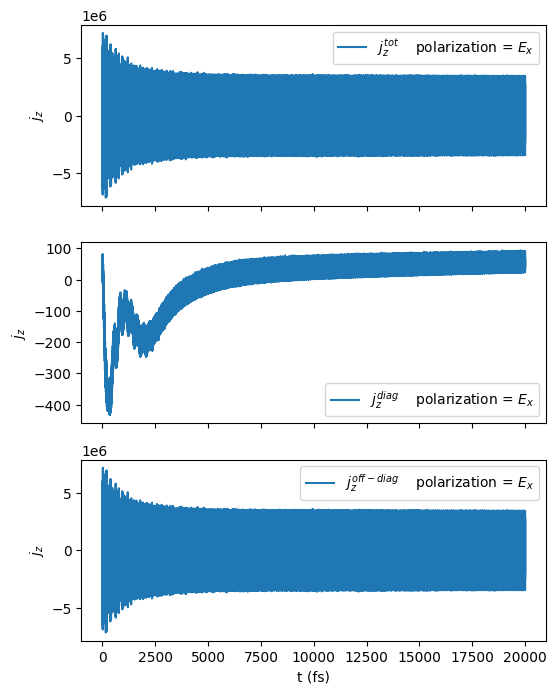

In [5]:
# plot different contributions

fig1, ax1 = plt.subplots(3,1, figsize=(6,8),sharex=True)

ax1[0].plot(jx_Ex_scat[:,0]/fs, jx_Ex_scat[:,1], label='$j_z^{tot}$    polarization = $E_x$')
ax1[0].set_ylabel('$j_z$')
ax1[0].legend()

ax1[1].plot(jx_Ex_scat[:,0]/fs, jx_Ex_scat[:,2], label=r'$j_z^{diag}$    polarization = $E_x$')
ax1[1].set_ylabel('$j_z$')
ax1[1].legend(loc='lower right')

ax1[2].plot(jx_Ex_scat[:,0]/fs, jx_Ex_scat[:,3], label=r'$j_z^{off-diag}$    polarization = $E_x$')
ax1[2].set_ylabel('$j_z$')
ax1[2].set_xlabel('t (fs)')
ax1[2].legend()

# save the graph to a file
fig1.savefig('jz-noscat-contrib.pdf')

jw_tot =  10.240466517602364
jw_d =  10.10474753023021
jw_od =  0.1357189873565106
j_d + j_od =  10.24046651758672


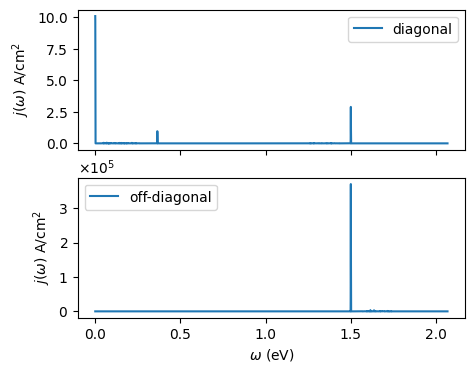

In [9]:
# FFT of different contributions

# as it is clear from the above graphs that there a transient at 
# at the start of dynamics. The transient can be removed by choosing 
# appropriate cutoff below

cutoff = 7000

f_tot, jw_tot = fft_of_j(jx_Ex_scat[:,0:2:1], cutoff)


f_d, jw_d = fft_of_j(jx_Ex_scat[:,0:3:2], cutoff)


f_od, jw_od = fft_of_j(jx_Ex_scat[:,0:4:3], cutoff)

print('jw_tot = ', abs(jw_tot[0]))
print('jw_d = ', abs(jw_d[0]))
print('jw_od = ', abs(jw_od[0]))
print('j_d + j_od = ', abs(jw_d[0] + jw_od[0]))


# Plot the FFT spectrum 

fig2, ax2 = plt.subplots(2,1,figsize=(5,4), sharex=True)

ax2[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2[1].yaxis.major.formatter._useMathText = True

ax2[0].plot(f_tot, abs(jw_d), label='diagonal')
ax2[0].set_ylabel('$j(\omega)$ A/cm$^2$')
ax2[0].legend()

ax2[1].plot(f_tot, abs(jw_od), label='off-diagonal')
ax2[1].set_ylabel('$j(\omega)$ A/cm$^2$')
ax2[1].set_xlabel('$\omega$ (eV)')
ax2[1].legend()

fig2.savefig('jz-noscat-contrib-fft.pdf')


## Occupations as a function of time

The DMD code can be made to write out occupations after every certain number of steps by setting `occup_write_interval` to the desired interval in the input file, `param.in`. Occupations file names would look like this,


`occupations-00000.out`  
`occupations-00100.out`  
`occupations-00200.out`  
`occupations-00300.out`  
`occupations-00400.out`  
`occupations-00500.out`  
`occupations-00600.out`

and so on if `occup_write_interval = 100`.

Below we plot $f (t)$ for conduction band.

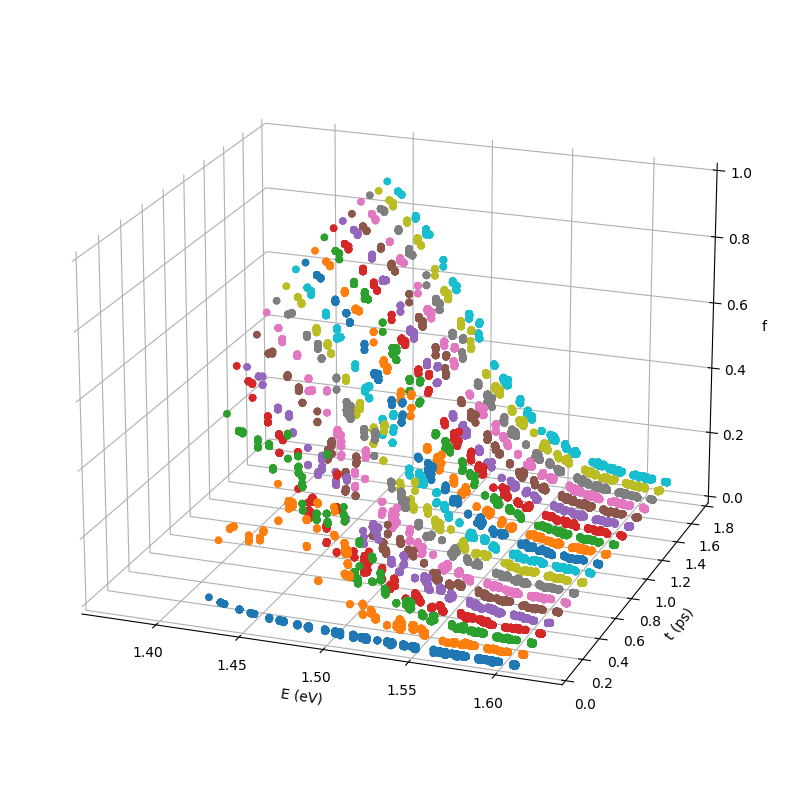

In [4]:
# Read all the occupations file names at once

occup_scat_files = sorted(glob.glob('occupations*out'))

# Read and plot data from one file at time 

fig = plt.figure(figsize=(12, 10))
ax =fig.add_subplot(111,projection='3d')


for index, file in enumerate(occup_scat_files):
    data = np.loadtxt(file)
    ax.scatter(data[:,0]*Hatree_to_eV, data[:,1], zs=index/10, zdir='y')
    
ax.set_xlim(0.05*Hatree_to_eV, 0.06*Hatree_to_eV)
ax.set_ylim(0, 1.8)
ax.set_zlim(0, 1)

ax.set_xlabel('E (eV)')
ax.set_ylabel('t (ps)')
ax.set_zlabel('f')
ax.xaxis.set_pane_color('w')
ax.yaxis.set_pane_color('w')
ax.zaxis.set_pane_color('w')

ax.view_init(elev=20., azim=-70, roll=0)

fig.savefig('occup-scattering-1.png', bbox_inches="tight")

### Steady state occupations
To see how steay the occuptations are, we can plot $\frac{df(t)}{dt}$. The quantity $\frac{df(t)}{dt}$ is not very easy to plot and visualize, for convenience one can plot $\left \{\frac{df(t)}{dt} \right \}_\mathrm{max}$.

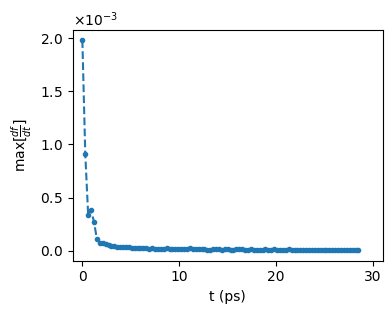

In [4]:
#
occup_scat_files_2 = sorted(glob.glob('occupations*out'))
dt = 300.0

n = len(occup_scat_files_2)
dfdt = np.full((n-1,5647), np.nan)

dfdtMax = np.full((n-1, 3), np.nan)

for ind in range(n-1):
    #if (ind*dt > 20000): break
    data0 = np.loadtxt(occup_scat_files_2[ind])
    data1 = np.loadtxt(occup_scat_files_2[ind+1])
    data  = (data1[:,1] - data0[:,1])/dt
    dfdtMax[ind,1] = max(data)
    dfdtMax[ind,2] = min(data)
    dfdt[ind,0] = ind*dt
    dfdt[ind,1:] = data
    
       
fig4, ax4 = plt.subplots(figsize=(4, 3))

#for index in range(5646):
#    ax4.plot(dfdt[:,0], dfdt[:,index+1])
    

ax4.plot(dfdt[:,0]/1000, dfdtMax[:,1], '--.')
#ax4.plot(dfdt[:,0], dfdtMax[:,2], '--')
#ax4.set_ylim(0,0.00003)
ax4.set_xlim(-1,31)
ax4.set_xticks(np.arange(0,40,10))

#ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0g}"))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.yaxis.major.formatter._useMathText = True

# Generate a colour vector
#kcolors = ['red' if value > limit else 'green' for value in dfdt[:,0]]


#ax4.plot(dfdtOne[:,0], dfdtOne[:,1], zorder=-1, c='black')
#ax4.scatter(dfdt[:,0], dfdt[:,1], c=kcolors)
ax4.set_xlabel('t (ps)')
ax4.set_ylabel(r'max$[\frac{df}{dt}]$')

fig4.savefig('dfdt-max.pdf')

## RhSi example

The analysis is very similar to the one above. Here is the input file for RhSi used to obtain the following data, 

```
#DEBUG = 1
restart = 0
#compute_tau_only = 1
code = jdftx
# alg_linearize = 1 # does not work with real time laser
print_along_kpath = 1
kpath_start1 = 0,0,0
kpath_end1 = 0.5000, 0.0000, 0.0000
alg_only_eimp = 0
alg_eph_sepr_eh = 1
alg_eph_need_elec = 1
alg_eph_need_hole = 0
alg_scatt = lindblad
alg_set_scv_zero = 1
alg_Pin_is_sparse = 0
alg_sparseP = 0
#alg_ddmdteq = 1
laserMode = constant
pumpMode = coherent
pumpA0 = 0.00050
pumpPoltype = LC
pumpE = 0.5
pumpTau = 10
pump_tcenter = 100
probePoltype = LC
#probePoltype2 = RC
probeEmin = 0.8
probeEmax = 2.0
probeDE = 0.005
probeTau = 100

# Bzpert = 0.1 # must be zero for pumpA0 > 0

t0 = 0
tend = 20000
tstep = 1
tstep_pump = 1
freq_measure_ene = 10
de_measure = 5e-4
degauss_measure = 2e-3

#alg_ode_method = euler
#ode_hstart = 0.01
#ode_hmin = 0.01
#ode_epsabs = 1e-04

mu = 0
carrier_density = 0

alg_phenom_relax = 0
tau_phenom = 0.11
bStart_tau = 0
bEnd_tau = 4

scrMode = medium
srcFormula = RPA
dynamic_screening = static
epsilon_background = 12.9

impurity_density = 0
impMode = model_ionized
#partial_ionized = 1
E_impurity = 1.43
Z_impurity = 1
g_impurity = 2
freq_update_eimp_model = 10

eeMode = Pee_update
#eeMode = Pee_fixed_at_eq
freq_update_ee_model = 10
```

In [3]:
# Read various files
jx_lc = np.loadtxt('LC/jx_elec_tot.out')
jy_lc = np.loadtxt('LC/jy_elec_tot.out')
jz_lc = np.loadtxt('LC/jz_elec_tot.out')

jx_rc = np.loadtxt('RC/jx_elec_tot.out')
jy_rc = np.loadtxt('RC/jy_elec_tot.out')
jz_rc = np.loadtxt('RC/jz_elec_tot.out')

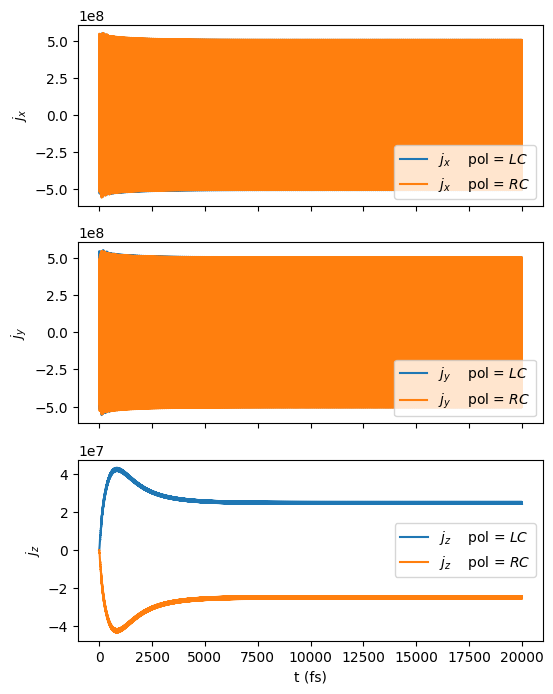

In [4]:
# Plot the time data

fig1, ax1 = plt.subplots(3,1, figsize=(6,8),sharex=True)



ax1[0].plot(jx_lc[:,0]/fs, jx_lc[:,1], label='$j_x$    pol = $LC$')
ax1[0].plot(jx_rc[:,0]/fs, jx_rc[:,1], label='$j_x$    pol = $RC$')
ax1[0].set_ylabel('$j_x$')
ax1[0].legend(loc='lower right')

ax1[1].plot(jy_lc[:,0]/fs, jy_lc[:,1], label=r'$j_y$    pol = $LC$')
ax1[1].plot(jy_rc[:,0]/fs, jy_rc[:,1], label=r'$j_y$    pol = $RC$')
ax1[1].set_ylabel('$j_y$')
ax1[1].legend(loc='lower right')

ax1[2].plot(jz_lc[:,0]/fs, jz_lc[:,1], label=r'$j_z$    pol = $LC$')
ax1[2].plot(jz_rc[:,0]/fs, jz_rc[:,1], label=r'$j_z$    pol = $RC$')
ax1[2].set_ylabel('$j_z$')
ax1[2].set_xlabel('t (fs)')
ax1[2].legend()

fig1.savefig('LCRC-RhSi.png')

In [5]:
# Do FFT and plot FFT data

cutoff = 1000
wxlc, jx_lc_w = fft_of_j(jx_lc[:,0:2], cutoff)
wylc, jy_lc_w = fft_of_j(jy_lc[:,0:2], cutoff)
wzlc, jz_lc_w = fft_of_j(jz_lc[:,0:2], cutoff)

wxrc, jx_rc_w = fft_of_j(jx_rc[:,0:2], cutoff)
wyrc, jy_rc_w = fft_of_j(jy_rc[:,0:2], cutoff)
wzrc, jz_rc_w = fft_of_j(jz_rc[:,0:2], cutoff)

jx_lc_0 =  125078.31061671472
jx_lc_mean = -592194.5887706203
jx_rc_0 =  123212.14203803519
jx_rc_mean = 565361.2889187883


jy_lc_0 =  109658.96936314068
jy_lc_mean = 529036.8317202877
jy_rc_0 =  124611.28259544028
jy_rc_mean = -616498.6849544565


jz_lc_0 =  5328663.426108848
jz_lc_mean = 25980308.340787668
jz_rc_0 =  5334152.564953308
jz_rc_mean = -26006248.95688292


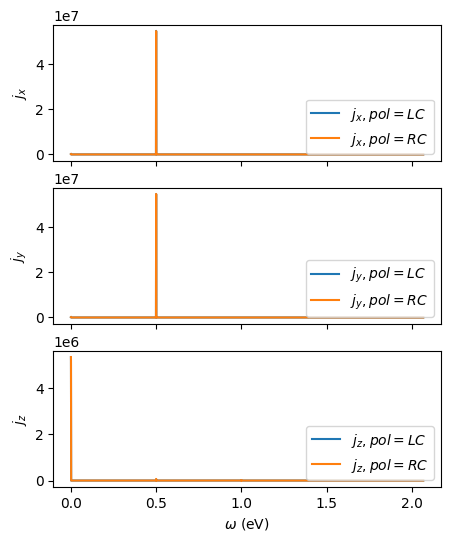

In [6]:
fig2, ax2 = plt.subplots(3,1,figsize=(5,6), sharex=True)

ax2[0].plot(wxlc, abs(jx_lc_w), label='$j_x, pol = LC$')
ax2[0].plot(wxrc, abs(jx_rc_w), label='$j_x, pol = RC$')
ax2[0].set_ylabel('$j_x$')
ax2[0].legend(loc='lower right')


ax2[1].plot(wylc, abs(jy_lc_w), label='$j_y, pol = LC$')
ax2[1].plot(wyrc, abs(jy_rc_w), label='$j_y, pol = RC$')
ax2[1].set_ylabel('$j_y$')
ax2[1].legend(loc='lower right')


ax2[2].plot(wzlc, abs(jz_lc_w), label='$j_z, pol = LC$')
ax2[2].plot(wzrc, abs(jz_rc_w), label='$j_z, pol = RC$')
ax2[2].set_ylabel('$j_z$')
ax2[2].set_xlabel('$\omega$ (eV)')
ax2[2].legend(loc='lower right')


print('jx_lc_0 = ', abs(jx_lc_w[0]))
print('jx_lc_mean =', np.mean(jx_lc[cutoff:,1]))
print('jx_rc_0 = ', abs(jx_rc_w[0]))
print('jx_rc_mean =', np.mean(jx_rc[cutoff:,1]))
print('\n')
print('jy_lc_0 = ', abs(jy_lc_w[0]))
print('jy_lc_mean =', np.mean(jy_lc[cutoff:,1]))
print('jy_rc_0 = ', abs(jy_rc_w[0]))
print('jy_rc_mean =', np.mean(jy_rc[cutoff:,1]))
print('\n')
print('jz_lc_0 = ', abs(jz_lc_w[0]))
print('jz_lc_mean =', np.mean(jz_lc[cutoff:,1]))
print('jz_rc_0 = ', abs(jz_rc_w[0]))
print('jz_rc_mean =', np.mean(jz_rc[cutoff:,1]))

fig2.savefig('LCRC-RhSi-FT.png')